<a href="https://colab.research.google.com/github/EvanWieland/Snitch/blob/main/SnitchTrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download data

In [ ]:
!wget https://github.com/EvanWieland/Snitch/raw/main/data.zip

--2021-08-31 23:01:00--  https://github.com/EvanWieland/Snitch/raw/main/data.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/EvanWieland/Snitch/main/data.zip [following]
--2021-08-31 23:01:00--  https://raw.githubusercontent.com/EvanWieland/Snitch/main/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12543547 (12M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  11.96M  --.-KB/s    in 0.06s   

2021-08-31 23:01:00 (188 MB/s) - ‘data.zip’ saved [12543547/12543547]



In [ ]:
!rm -rf data

!unzip data.zip -d data
!unzip data/train.zip -d data
!unzip data/test.zip -d data


Streaming output truncated to the last 5000 lines.
  inflating: data/train/7bc54bf1a7e9988f2b7ad70eae9200a0.jpg  
  inflating: data/train/7bdb88b4e816d3094c8b3b5b2386e436.jpg  
  inflating: data/train/7bed9596047ca6452e723a22dc1215a6.jpg  
  inflating: data/train/7c3556d5bbd3f96ee71597b635e2d179.jpg  
  inflating: data/train/7c613074e1725da55956fc58a10a128b.jpg  
  inflating: data/train/7d7e1d15aaa88da898118e58873a3ce6.jpg  
  inflating: data/train/7da5d475a405821afd70635a87e35564.jpg  
  inflating: data/train/7db4391b63c19ff29e57323cf3b226eb.jpg  
  inflating: data/train/7dcc67717f845e692ea9e793ed807964.jpg  
  inflating: data/train/7dd0044c023e31c204c5b4e2d483d4da.jpg  
  inflating: data/train/7e12e683356111f3778f8fdfd13a4f89.jpg  
  inflating: data/train/7e2378b48432821bcdaea804a56bc5ce.jpg  
  inflating: data/train/7e43991fe09943006c8313417d9e8d14.jpg  
  inflating: data/train/7ee9407aa335dfa4bb65ebbeef5c029b.jpg  
  inflating: data/train/7f34c065bd90f8d96a361606aafa1679.jpg  
  in

# Import deps

In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import Image, display

print(tf.__version__)

2.6.0


# Inspect data

In [ ]:
train_csv = pd.read_csv('data/train.csv')
print(train_csv.describe())
print(train_csv.head())

         has_cactus
count  17500.000000
mean       0.750629
std        0.432662
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
                                     id  has_cactus
0  0004be2cfeaba1c0361d39e2b000257b.jpg           1
1  000c8a36845c0208e833c79c1bffedd1.jpg           1
2  000d1e9a533f62e55c289303b072733d.jpg           1
3  0011485b40695e9138e92d0b3fb55128.jpg           1
4  0014d7a11e90b62848904c1418fc8cf2.jpg           1


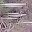

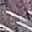

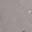

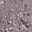

In [ ]:
# Cactus
display(Image('data/train/0004be2cfeaba1c0361d39e2b000257b.jpg'))
display(Image('data/train/000c8a36845c0208e833c79c1bffedd1.jpg'))

# No cactus
display(Image('data/train/ffede47a74e47a5930f81c0b6896479e.jpg'))
display(Image('data/train/fff43acb3b7a23edcc4ae937be2b7522.jpg'))

# Preprocess Data

In [ ]:
# Prepend image filenames in train/ with relative path
filenames = ['data/train/' + fname for fname in train_csv['id'].tolist()]
labels = train_csv['has_cactus'].tolist()

# Split into training and validation file sets
train_filenames, val_filenames, train_labels, val_labels = train_test_split(filenames,
                                                                            labels,
                                                                            train_size=0.9,
                                                                            random_state=420)
# Train file count
num_train = len(train_filenames)
# Validate file count
num_val = len(val_filenames)

In [ ]:
# Minimum image size for use with MobileNetV2
IMAGE_SIZE = 96

# Function to load and preprocess each image
def _parse_fn(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string)
  image_normalized = (tf.cast(image_decoded, tf.float32)/127.5) - 1
  image_resized = tf.image.resize(image_normalized, (IMAGE_SIZE, IMAGE_SIZE))
  return image_resized, label

In [ ]:
# Run _parse_fn over each example in train and val datasets
# Also shuffle and create batches

BATCH_SIZE = 32

train_data = tf.data.Dataset.from_tensor_slices(
    (tf.constant(train_filenames), tf.constant(train_labels))
    ).map(_parse_fn).shuffle(buffer_size=10000).batch(BATCH_SIZE)


val_data = tf.data.Dataset.from_tensor_slices(
    (tf.constant(val_filenames), tf.constant(val_labels))
    ).map(_parse_fn).batch(BATCH_SIZE)

# Define Model

In [ ]:
# Base model with MobileNetV2
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')
base_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# Trainable classification head
maxpool_layer = tf.keras.layers.GlobalMaxPooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

In [ ]:
learning_rate = 0.0001

model = tf.keras.Sequential([
    base_model,
    maxpool_layer,
    prediction_layer
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


# Train

In [ ]:
num_epochs = 30
steps_per_epoch = round(num_train)//BATCH_SIZE
val_steps = 20

In [ ]:
history = model.fit(train_data.repeat(),
                    epochs=num_epochs,
                    steps_per_epoch = steps_per_epoch,
                    validation_data=val_data.repeat(), 
                    validation_steps=val_steps)

Epoch 1/30
492/492 [==============================] - 92s 174ms/step - loss: 0.3215 - accuracy: 0.8634 - val_loss: 0.1359 - val_accuracy: 0.9469
Epoch 2/30
492/492 [==============================] - 94s 192ms/step - loss: 0.1071 - accuracy: 0.9614 - val_loss: 0.0947 - val_accuracy: 0.9625
Epoch 3/30
492/492 [==============================] - 93s 188ms/step - loss: 0.0775 - accuracy: 0.9725 - val_loss: 0.0762 - val_accuracy: 0.9734
Epoch 4/30
492/492 [==============================] - 98s 198ms/step - loss: 0.0635 - accuracy: 0.9771 - val_loss: 0.0668 - val_accuracy: 0.9797
Epoch 5/30
492/492 [==============================] - 98s 199ms/step - loss: 0.0547 - accuracy: 0.9803 - val_loss: 0.0605 - val_accuracy: 0.9844
Epoch 6/30
492/492 [==============================] - 99s 200ms/step - loss: 0.0491 - accuracy: 0.9819 - val_loss: 0.0561 - val_accuracy: 0.9844
Epoch 7/30
492/492 [==============================] - 98s 200ms/step - loss: 0.0439 - accuracy: 0.9845 - val_loss: 0.0527 - val_ac

In [ ]:
# Save model weights
# model.save_weights('weights_epoch_30.h5')

# Save model
model.save("epoch_30.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


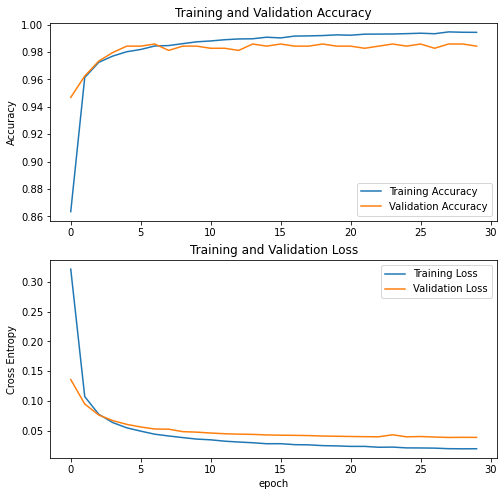

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine Tune

In [ ]:
# Unfreeze all layers of MobileNetV2
base_model.trainable = True

# Refreeze layers until the layers we want to fine-tune
for layer in base_model.layers[:100]:
  layer.trainable =  False

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate/10),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,862,721
Non-trainable params: 396,544
_________________________________________________________________


In [ ]:
fine_tune_epochs = 30
total_epochs =  num_epochs + fine_tune_epochs

history_fine = model.fit(train_data.repeat(), 
                         steps_per_epoch = steps_per_epoch,
                         epochs=total_epochs, 
                         initial_epoch = num_epochs,
                         validation_data=val_data.repeat(), 
                         validation_steps=val_steps)

Epoch 31/60
492/492 [==============================] - 243s 481ms/step - loss: 0.1567 - accuracy: 0.9541 - val_loss: 0.1243 - val_accuracy: 0.9656
Epoch 32/60
492/492 [==============================] - 222s 451ms/step - loss: 0.0818 - accuracy: 0.9746 - val_loss: 0.0547 - val_accuracy: 0.9812
Epoch 33/60
492/492 [==============================] - 213s 432ms/step - loss: 0.0581 - accuracy: 0.9804 - val_loss: 0.0464 - val_accuracy: 0.9844
Epoch 34/60
492/492 [==============================] - 216s 438ms/step - loss: 0.0372 - accuracy: 0.9863 - val_loss: 0.0408 - val_accuracy: 0.9891
Epoch 35/60
492/492 [==============================] - 225s 456ms/step - loss: 0.0263 - accuracy: 0.9904 - val_loss: 0.0373 - val_accuracy: 0.9891
Epoch 36/60
492/492 [==============================] - 212s 431ms/step - loss: 0.0238 - accuracy: 0.9914 - val_loss: 0.0415 - val_accuracy: 0.9875
Epoch 37/60
492/492 [==============================] - 212s 431ms/step - loss: 0.0171 - accuracy: 0.9942 - val_loss: 0

In [ ]:
# Save fine-tuned model weights
# model.save_weights('weights_epoch_60_finetuned.h5')

# Save model
model.save("epoch_60_finetuned.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

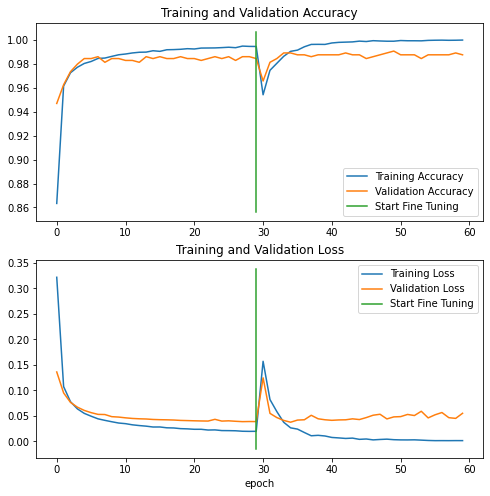

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([num_epochs-1,num_epochs-1], 
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([num_epochs-1,num_epochs-1], 
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()